# A short instrument model of the static thermal gradient diffusion chamber

Markus Petters <br>
Department of Marine, Earth, and Atmospheric Sciences <br>
NC State University <br>
Raleigh, NC 27695-8208 <br>
Email:mdpetter@ncsu.edu <br>
<br>
May 16,2019

In [1]:
using Plots, Plots.PlotMeasures, DifferentialMobilityAnalyzers, Distributions, Random
using DifferentialEquations, ParameterizedFunctions, Distributed, StatsBase, SpecialFunctions
plotlyjs();

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-6196478065909271197\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4462343946938580073\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/2543b61946cfbfb279b4f01ff6b02977f9fcee1b-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-6196478065909271197\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

### A. Chamber model

A droplet of radius $r$ and vertical position $z$ is governed by the following coupled differential equations <br><br>


<center> $ r \frac{dr}{dt} = G(T) \left (s^{\mathrm{chamber}}(z) - s^{\mathrm{drop}}(r) \right ) $ </center><br><br>

<center> $ \frac{dz}{dt} = -v_t(r) $ </center> <br><br>

where $r$ is the droplet radius, $ s = \left (s^{\mathrm{chamber}}(z)-s^{\mathrm{drop}}(r) \right )\times 100 $  is the supersaturation over the droplet, $G(T) = \frac{1}{F_D+F_H}$ is the growth parameter with $F_D$ and $F_H$ representing the resistance due to diffusion and $T$ denoting temperature; $v_t(r)$ is the terminal velocity, $s^{\mathrm{chamber}}(z)$ is the fractional supersaturation in the chamber at location $z$ and $s^{\mathrm{drop}}$ is the fractional supersaturation over the drop with dry diameter $D_d$.  

The functions $G(T)$, $v_t(r)$, $s^{\mathrm{drop}}(r)$, $s^{\mathrm{chamber}}(z)$ are straightforward to compute.

In [2]:
const ρw = 997.1                # Water denity [kg m-3]
const lv = 2.5e6                # Latent heat of vaporization [J kg-1]
const R = 8.314                 # Universal gas constant [J K-1 mol-1] = [N m K-1 mol-1]
const Mw = 18.05e-3             # Molecular weight of water [kg mol-1]
const Dv = 2.11e-5              # Diffusion constant of water [m2 s-1]
const K = 0.02587               # Heat conductivity [J s-1 m-1 K-1]
const g = 9.81                  # Acceleration due to gravity [m s-2]
const Rd = 287.15               # Specific gas constant of dry air [J kg K]
const A = 2.1e-9                # Kelvin diameter [m] 

es(T::Float64) = 610.94*exp(17.625*(T-273.15)/((T-273.15)+243.04)) # Saturation vapor pressure, T in [C]
λ(T::Float64,p::Float64) = 6.6e-8*(101315/p)*(T/293.15)            # Mean free path of air
η(T::Float64) = 1.83245e-5*exp(1.5*log(T/296.1))*(406.55)/(T+110.4)                   # viscosity of air
Cc(T::Float64,p::Float64,d::Float64) = 1.0+λ(T,p)/d*(2.34+1.05*exp.(-0.39*d/λ(T,p)))  # Slip correction
ρg(T::Float64,p::Float64) = p/(Rd*T)                                                  # Air density
Re(v::Float64,d::Float64,T::Float64,p::Float64) = ρg(T,p)*v*d/η(T)                    # Reynold's number
Cd(Re::Float64) = (Re < 0.1) ? 24/Re : 24/Re.*(1+0.15*Re^0.687)                       # Drag coefficient 
sᵈʳᵒᵖ(D::Float64, Dd::Float64) = (D^3.0-Dd^3)/(D^3.0-Dd^3*(1-κ))*exp(A/D)-1.0;        # Supersaturation over drop

function sᶜʰᵃᵐᵇᵉʳ(z::Float64, ΔT::Float64)    # Supersaturation profile in CCN chamber vs. height
    e = es(T)+(es(T + ΔT)-es(T))*z/zt
    s = (e/es(T + ΔT*z/zt)-1)
    (s < 0) ? 0 : s
end

function G(T::Float64)                        # Growth parameter G vs. temperature
    FD = (ρw*R*T)/(es(T)*Dv*Mw)
    FH = (lv*ρw)/(K*T)*((lv*Mw)/(T*R)-1.0)
    1/(FD + FH)
end

function vt(d::Float64)                       # Terminal velocity vs. diameter
    vts1 = (d,v) -> (4*ρp*d*g*Cc(T,p,d)/(3*Cd(Re(v,d,T,p))*ρg(T,p)))^0.5
    vts2 = (d,v) -> (vts1(d,v)-v)^2 < 1e-30 ? v : vts2(d,vts1(d,v))
    vts2(d, 1e-5)
end

ODEs = @ode_def_bare begin                    # Trajectory ODEs
  dr = G*(sᶜʰᵃᵐᵇᵉʳ(z,ΔT)-sᵈʳᵒᵖ(2.0*r,Dd))/r
  dz = -vt(2.0*r)
end G Dd ΔT;

### B. Compute Trajectories
Particles are distributed uniformly through the chamber. The size distribution is described using a log normal function with mode particle diameter $D_g$ and geometric standard deviation $\sigma_g$. Particle composition is described using the hygroscopicity parameter $\kappa$. The chamber supersaturation profile is set by the instrument $\Delta T$. A total of $n$ particles is simulated, using position and size drawn from a random number generator. Only positions above starting slightly below the centerline are considered. Chamber dimensions can be set using the maximum chamber height $zt$. The set of ODEs is integrated over $t$ seconds. 

Note that the ODEs are stiff, requiring low tolerance for the solution to converge. Solver speed is inversely proportional to tolerance and 1e-8 works for many instances. However, it fail for some "odd" intial sizes and there are probably ways to optimize the setup if many simulations are needed. The solution speed may be increased by supplying appropriate derivatives. For testing purposes decreases the number of particles to 10 and/or solve for fewer supersaturations. 

In [3]:
T, p, ρp = 298.15, 1e5, 1000.0  # Temperature [K] and Pressure [Pa] and Particle density [kg m-3]
t, n, zt = 20.1, 1000, 0.01     # ODE integration time [s] and number of particles [#] and chamber height [m]
Dg, σ, κ = 80e-9,1.3,0.6        # Mode diameter [m], geometric standard deviation [-], kappa
a, b = 0.004, zt*0.95           # Range of chamber that particles are modeled [min, max]
ss = [0.5 0.4 0.3 0.2 0.1]      # Solve for ss = [0.5, 0.4. 0.3, 0.2, 0.1]% (need to specify ΔT vals below)

solutions = map([3.63, 3.24, 2.8, 2.28, 1.6]) do ΔT
    Dd,z0 = rand(LogNormal(log(Dg), log(σ)), n), rand(Uniform(a, b), n)
    map(i->solve(ODEProblem(ODEs,[Dd[i];z0[i]],(0.0,t),[G(T),Dd[i],ΔT]), 
        alg_hints=[:stiff],abstol=1e-11,reltol=1e-11), 1:n)
end;

### C. Trajectory Visualization

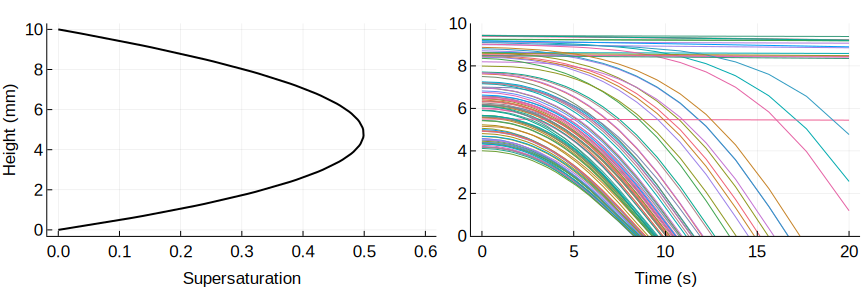

In [8]:
figure("Helvetica", 2, 6,2,8)
sol = solutions[1]
t = exp10.(range(log10(0.0001), stop=log10(20), length=100))
p1 = plot(100*sᶜʰᵃᵐᵇᵉʳ.(0:0.0001:zt, 3.63), 1000*(0:0.0001:zt), color = :black, ytick = [0,2,4,6,8,10], lw = 2, 
    ylabel = "Height (mm)", xlabel = "Supersaturation", xlim = [0, 0.6])
p2 = plot([0, 0], [0, 0], fmt = :svg, ylim = (0,10), xlabel = "Time (s)", legend = :none)
map(i->plot!(t, 1000*(hcat(sol[i](t)...))[2,:]),1:100)
plot(p1, p2, layout = grid(1,2))

<b> Figure 1. </b> Left: Vertical supersaturation profile for ΔT=3.63K. Right: Height vs. time trajectories for $n = 100$ randomly selcted particles. Particles that do not settle remain unactivated. Below 4 mm height no particles are simulated because they are not being observed in the centerline (4-6 mm).

### D. Observable centerline properties

In [5]:
function process_solution(sol,t)
    extract = map(t->hcat(map(i->[(sol[i](t))[1]; (sol[i](t))[2]], 1:n)...)', t)
    Dpvst = hcat(map(i->(extract[i])[:,1], 1:length(t))...)  # Diameter
    zvst  = hcat(map(i->(extract[i])[:,2], 1:length(t))...)  # Vertical position
    vtvst = vt.(Dpvst)*1000                                  # Velocity in mm/s
    f = i->(zvst[:,i] .> 0.004) .& (zvst[:,i] .< 0.006) .& (Dpvst[:,i] .> 0.75e-6)
    t,  map(i->sum(f(i)), 1:length(t)), map(i->mean((vtvst[:,i])[f(i)]), 1:length(t)), 
        map(i->std((vtvst[:,i])[f(i)]), 1:length(t))
end

data = map(sol->process_solution(sol,0.1:0.1:20), solutions);

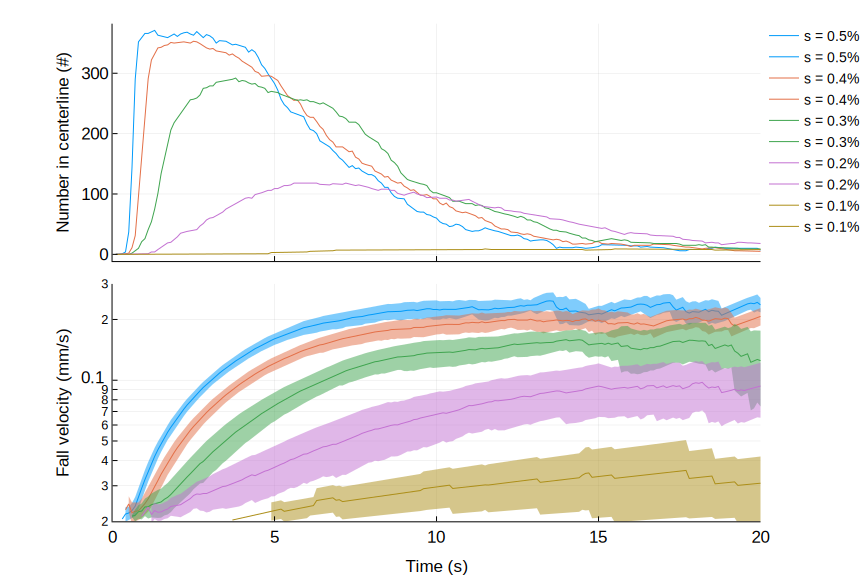

In [6]:
figure("Helvetica", 2, 6,4,8)
t, Nvst, muvt, stdvt = (data[1])[1], (data[1])[2], (data[1])[3], (data[1])[4]
p1 = plot(t, Nvst, label = "s = $(ss[1])%", ylabel = "Number in centerline (#)", 
    xticks = ([0, 5, 10, 15, 20], ["", "", "", "", "", ""]))
map(i->plot!((data[i])[1], (data[i])[2], label = "s = $(ss[i])%"),2:length(solutions))

p2 = plot(t[.~isnan.(muvt)], muvt[.~isnan.(muvt)], ribbon=stdvt[.~isnan.(muvt)], fillalpha=.5, yscale = :log10, 
    label = "s = 0.5%", ylabel = "Fall velocity (mm/s)", xlabel = "Time (s)", ylim = (0.02, 0.3))
map(2:length(solutions)) do i
    t, Nvst, muvt, stdvt = (data[i])[1], (data[i])[2], (data[i])[3], (data[i])[4]
    plot!(t[.~isnan.(muvt)], muvt[.~isnan.(muvt)], ribbon=stdvt[.~isnan.(muvt)], fillalpha=.5, 
        label = "s = $(ss[i])%")
end

plot(p1,p2, layout = grid(2,1), xlim = (0,20), fmt = :svg)

<b> Figure 2. </b> Top: Number of particles with D > 1 micron in the centerline, defined as the region between 4-6 mm. Bottom: mean +/- 1 standard deviation of the particle velocity for particle with D > 0.75 micron present in the centerline. The observed velocity distribution and number is sensitive to the assumed lower threshold diameter. 

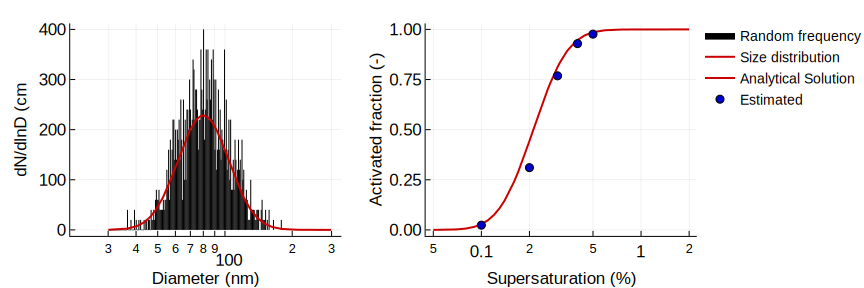

In [7]:
figure("Helvetica", 2, 6, 2, 8)
Nmax = map(x->maximum(x[2]), data)
ψ(s) = (4/27)^(1/3)*A/(κ^(1/3)*Dg*log(s/100+1)^(2/3))
Af(s) = 1/2*erfc(log.(ψ.(s))/(sqrt(2)*log(σ)))
Dact(s) = (4*A^3/(27*κ*log(s/100+1)^2))^(1/3)
s = 0.05:0.01:2
𝕟 = lognormal([[150, Dg*1e9, σ]]; d1 = 30.0, d2 = 300.0, bins = 256) 
h = fit(Histogram, rand(LogNormal(log(1e9Dg), log(σ)), n), 𝕟.De)
p1 = plot(𝕟.Dp, h.weights*20, fmt =:svg, lt = :bar, color = :black, label = "Random frequency")
p1 = plot!(𝕟.Dp, 𝕟.S, xscale = :log10, color = RGB(0.8,0,0), lw = 2, 
    xlabel = "Diameter (nm)", ylabel = "dN/dlnD (cm<sup>-3</sup>)", label = "Size distribution")
p2 = plot(s, Af.(s), xscale = :log10, color = RGBA(0.8, 0, 0), lw = 2,
    xlabel = "Supersaturation (%)", ylabel = "Activated fraction (-)", label = "Analytical Solution")
p2 = plot!(ss', Nmax./380, lw = 0, marker = :circle, ms = 4, color = RGB(0,0,0.8), label = "Estimated")
plot(p1, p2, layout = grid(1,2), fmt = :svg, left_margin = 30px)

<b> Figure 3. </b> Left: Assumed size distribution for trajectory simulatations (solid line), and frequency of particles selected by the random number gnerator (bars). Numbers are scaled for visual comparison. Right: Analytical solution of the activated fraction and estimated activated fraction based on maximum observed number concentration in the centerline of the chamber.